# Reinforcement Learning
Prof. Milica Gašić

### Proximal Policy Optimization (PPO)


PPO is an actor-critic approach, i.e. it trains two neural networks:
- *Actor*: The policy network that computes $\pi_\theta(a | s)$.
- *Critic*: The value function network that computes $\hat{v}(s, w)$.

**Actor Optimization**:

For a state and action $s_t,a_t$, define the probability ratio 
$$
r_t({\theta}) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)},
$$
where $\pi_{\theta_{\text{old}}}$ is the policy that selected action $a_t$ in state $s_t$. PPO optimizes the actor $\pi_\theta$ through the clipped surrogate objective $\mathcal{L}^\text{clip}$, defined by

$$
\begin{align}
\mathcal{L}_1(\theta) &= r_t({\theta}) \cdot a_\theta(s_t, a_t) \\
\mathcal{L}_2(\theta) &= \text{clip}(r_t({\theta}), 1 - \epsilon, 1 + \epsilon) \cdot a_\theta(s_t, a_t) \\
\mathcal{L}^\text{clip}(\theta) &= - \mathbb{E}_{\pi_{\theta_{\text{old}}}} \left[\text{min}(\mathcal{L}_1(\theta), \mathcal{L}_2(\theta)) \right]
\end{align}
$$
where the clip function will clip the value $r_t({\theta})$ into the interval $[1-\epsilon, 1+\epsilon]$.

**Generalized Advantage Estimates (GAE)**:

The advantage $a_\theta(s_t, a_t)$ is estimated through the so-called generalized advantage estimates. For a time-step $t$ and future time-step $T$, it is defined by
$$
\begin{align}
a_\theta(s_t, a_t) &= \delta_t + (\gamma \lambda) \delta_{t+1} + ... + (\gamma \lambda)^{T-t+1} \delta_{T-1}, \\
\delta_t &= r_{t+1} + \gamma \hat{v}(s_{t+1}, w) - \hat{v}(s_t, w)
\end{align}
$$
where $\gamma$ is the usual discount factor and $\lambda$ is a hyperparamter. Try to answer the following questions:

- What happens for $\lambda = 0$. Does the advantage look familiar to you?
- What happens for $\lambda = 1$. Does the advantage look familiar to you?
- Why is it called generalized advantage estimate?

**Critic Optimization**:  

In order to calculate the advantage, we optimize a critic network $\hat{v}(s, w)$. This is done as follows:
$$
\begin{align}
v_\text{target} &= a_\theta(s_t, a_t) + \hat{v}(s_t, w) \\
\mathcal{L}_\text{VF}(w) &= \mathbb{E}_{\pi_\theta} \left[ (\text{sg}(v_\text{target}) - \hat{v}(s_t, w))^2 \right]
\end{align}
$$
where sg denotes stop gradient.

**Algorithm**:

In last week's exercise, we started $N$ environments, executed an environment step in each of them and performed the actor-critic update. PPO uses a generalized approach, where in each environment we execute $T$ many environment steps and then perform $K$ updates using the data. If $T=K=1$, we obtain the approach of last week's exercise. The PPO algorithm is explained below:

- Create $N$ environment instances
- for iteration = $1, 2, ...$
    - for environment $1, 2, ..., N$
        - execute $T$ steps in the environment using policy $\pi_{\theta_{\text{old}}}$ for action selection
        - save the generated data of states, actions, rewards, next states and terminations
    - For epoch=1, ..., K
        - Update the actor and critic network by minimizing the losses $\mathcal{L}^\text{clip}$ and $\mathcal{L}_\text{VF}$

### Implementation

Make sure that the files `rl_gui.py` and `rl_tests.py` are in the same folder as the notebook.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from tqdm.auto import tqdm, trange

import rl_gui
import rl_tests

#### PPO Agent

The class `PPO` is a subclass of `torch.nn.Module`, which takes care of the automatic differentiation.  
It contains both networks for the actor and the critic.  
Your task is to finish the implementation.

We provide two utility functions that might be helpful:

In [2]:
def select_at_index(x, indices):
    # Extracts the elements from x at the specified indices, i.e.,
    # result[i] = x[i, indices[i]] for all i.
    # - x has shape (batch_size, d)
    # - indices has shape (batch_size)
    # - the result has shape (batch_size)
    return x.gather(-1, indices.unsqueeze(-1)).squeeze(-1)


def sample_categorical(probs):
    # Samples from a categorical distribution (e.g. with probabilities computed with softmax).
    # - probs has shape (batch_size, d)
    # - the result has shape (batch_size)
    return torch.multinomial(probs, 1, replacement=True).squeeze(1)

In [3]:
class PPO(nn.Module):

    def __init__(self, state_dim, num_actions, gamma, lmbda, epsilon, num_steps):
        super().__init__()
        self.gamma = gamma  # discount factor
        self.lmbda = lmbda
        self.epsilon = epsilon
        self.num_steps = num_steps

        # actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

        # critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def select_actions(self, states):
        # states has shape (batch_size, state_dim)
        # compute the scores for the given states
        scores = self.actor(states)
        # scores has shape (batch_size, num_actions)

        probs = torch.softmax(scores, dim=1)
        actions = sample_categorical(probs)
        return actions

    def compute_log_probs(self, states, actions):
        # states has shape (batch_size, state_dim)
        # actions has shape (batch_size)
        # compute the scores for the given states
        scores = self.actor(states)
        # scores has shape (batch_size, num_actions)

        logit_at_action = select_at_index(scores, actions)
        log_sum_exp = torch.logsumexp(scores, dim=1)
        log_probs = logit_at_action - log_sum_exp

        return log_probs

    def compute_values(self, states):
        # states has shape (batch_size, state_dim)
        # compute values for the batch of states using the critic network
        values = self.critic(states).squeeze(-1)
        # values has shape (batch_size)
        return values

    def compute_advantages(self, states, rewards, next_states, terminations):
        # for every of the N environments 0, ..., N-1, we collected T transitions
        # state/next_state has shape (N * T, state_dim)
        # rewards and terminations have shape (N * T)
        # the states for environment i are saved in states[i*T:(i+1)*T, :]
        # the rewards for environment i are saved in rewards[i*T:(i+1)*T]
        # etc...

        gamma = self.gamma  # discount factor
        lmbda = self.lmbda  # for generalized advantage estimation
        T = self.num_steps  # number of transitions per environment
        num_states = states.size()[0]  # has size N * T

        ##############################################################################
        # TODO Compute the advantages (GAE) and critic targets as described above.   #
        # advantages and critic_targets should be torch.Tensors in the end.          #
        # Hint: Iterate backwards for computing the advantages.                      #
        # Remember to potentially reverse the advantage list afterwards.             #
        # Don't forget to take care of the termination signals.                      #
        # Be careful that some transitions can come from different environments.     #
        ##############################################################################

        N, state_dim = states.size(0) // self.num_steps, states.size(1)
        states = states.reshape(N, T, state_dim)
        next_states = next_states.reshape(N, T, state_dim)
        rewards = rewards.reshape(N, T)
        terminations = terminations.reshape(N, T)

        values = self.compute_values(states)
        next_values = self.compute_values(next_states)

        td_errors = rewards + gamma * next_values * ~terminations - values

        advantages = torch.zeros_like(rewards)
        gae = torch.zeros(N)

        for t in reversed(range(T)):
            gae = td_errors[:, t] + gamma * lmbda * gae * ~terminations[:, t]
            advantages[:, t] = gae.squeeze()

        critic_targets = advantages + values

        return advantages.reshape(-1).detach(), critic_targets.reshape(-1).detach()

    def compute_loss(self, states, actions, advantages, critic_targets, log_probs_old):
        # states has shape (batch_size, state_dim)
        # actions, advantages, critic_targets, and log_probs_old have shape (batch_size)
        # log_probs_old are given by \pi_\theta_old(a_t | s_t)

        epsilon = self.epsilon

        #########################################################################
        # TODO Compute the loss for the actor (L^clip) and the critic (L_VF) as #
        # described above. The expectations are approximated by taking the      #
        # average over the batch (i.e., use `x.mean()`).                        #
        # Hint: you can use torch.clamp() for clipping values                   #
        #########################################################################

        logits = self.actor(states)
        probs = torch.softmax(logits, dim=1)
        probs = select_at_index(probs, actions)

        r_theta = probs / log_probs_old.exp()

        L_1 = r_theta * advantages
        L_2 = torch.clamp(r_theta, 1 - epsilon, 1 + epsilon) * advantages
        actor_loss = -torch.min(L_1, L_2).mean()
        
        critic_loss = ((critic_targets - self.compute_values(states)) ** 2).mean()

        # return both losses
        return actor_loss, critic_loss

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [4]:
torch.set_printoptions(precision=8)


def test_ppo():
    torch.manual_seed(42)
    rng = np.random.Generator(np.random.PCG64(seed=42))
    state_dim = 5
    num_actions = 3
    gamma = 0.8
    lmbda = 0.95
    epsilon = 0.2
    num_collection_steps = 1
    ac = PPO(state_dim, num_actions, gamma, lmbda, epsilon, num_collection_steps)
    with torch.no_grad():
        for layer in (ac.actor[0], ac.actor[2], ac.actor[4], ac.critic[0], ac.critic[2], ac.critic[4]):
            mean = rng.uniform(-0.5, 0.5)
            layer.weight[:] = torch.as_tensor(rng.normal(mean, 0.1, layer.weight.shape))
            nn.init.zeros_(layer.bias)

    sample_states = lambda batch_size: torch.as_tensor(rng.standard_normal((batch_size, state_dim), dtype=np.float32))
    sample_actions = lambda batch_size: torch.as_tensor(rng.choice(num_actions, batch_size))

    yield 'compute_advantages()'
    for expected_advantages in [
        [0.01287864, 1.91237950, 0.50822473, 1.22912478],
        [-0.18249962, 0.55023891, 0.32651904, 2.21070695, 0.97387546],
        [0.73423117, -2.70612144, -1.03495073, -0.23954383, -0.12438969, 1.06986928, -0.15151261]
    ]:
        batch_size = len(expected_advantages)
        states = sample_states(batch_size)
        expected_advantages = torch.as_tensor(expected_advantages)
        rewards = torch.randn(batch_size, dtype=torch.float32)
        next_states = sample_states(batch_size)
        terminations = torch.rand(batch_size) < 0.5
        advantages, _ = ac.compute_advantages(states, rewards, next_states, terminations)

        if (yield from rl_tests.check_torch_tensor(advantages, 'advantages', shape=(batch_size,), dtype=torch.float32)):
            yield torch.allclose(advantages, torch.as_tensor(
                expected_advantages)), f'advantages are incorrect (error = {torch.sum(torch.abs(advantages - expected_advantages)).item()})'
        yield None

    yield 'compute_loss()'
    for batch_size, expected_actor_loss, expected_critic_loss in [
        (4, -0.27133098, 3.71168423),
        (8, 0.30093294, 0.64200860),
        (12, -0.15494117, 0.97636366)
    ]:
        states = sample_states(batch_size)
        actions = sample_actions(batch_size)
        next_states = sample_states(batch_size)
        terminations = torch.rand(batch_size) < 0.5
        rewards = torch.randn(batch_size, dtype=torch.float32)
        #advantages = torch.randn(batch_size, dtype=torch.float32)
        #critic_targets = torch.randn(batch_size, dtype=torch.float32)
        advantages, critic_targets = ac.compute_advantages(states, rewards, next_states, terminations)
        log_probs_old = torch.randn(batch_size, dtype=torch.float32)

        actor_loss, critic_loss = ac.compute_loss(states, actions, advantages, critic_targets, log_probs_old)
        if (yield from rl_tests.check_torch_tensor(actor_loss, 'actor_loss', shape=tuple(), dtype=torch.float32)):
            expected_actor_loss = torch.tensor(expected_actor_loss)
            yield torch.isclose(actor_loss, expected_actor_loss), f'actor_loss is incorrect (error = {(actor_loss - expected_actor_loss).item()})'
            yield actor_loss.requires_grad, 'gradients disabled for actor_loss'
        if (yield from rl_tests.check_torch_tensor(critic_loss, 'critic_loss', shape=tuple(), dtype=torch.float32)):
            expected_critic_loss = torch.tensor(expected_critic_loss)
            yield torch.isclose(critic_loss, expected_critic_loss), f'critic_loss is incorrect (error = {(actor_loss - expected_critic_loss).item()})'
            yield critic_loss.requires_grad, 'gradients disabled for critic_loss'
        yield None


rl_tests.run_tests(test_ppo())

Testing compute_advantages()...
3/3 tests passed!

Testing compute_loss()...
3/3 tests passed!


### Evaluation

We will evaluate the algorithm on the LunarLander environment.  
Please read the documentation: https://gymnasium.farama.org/environments/box2d/lunar_lander/

If an error occurs, you might have to install the `box2d` environments first:  
`pip install gymnasium[box2d]`

In [5]:
def create_env(seed):
    env_id = 'LunarLander-v3'
    env = gym.make(env_id, render_mode='rgb_array')
    env.reset(seed=seed)
    return env

Evaluate a random policy:

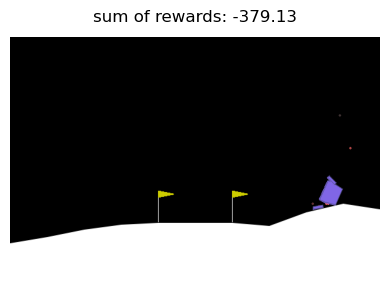

In [6]:
env = create_env(seed=42)
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

env.reset()
render()
reward_sum = 0.0
for _ in range(200):
    action = env.action_space.sample()
    _, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'sum of rewards: {reward_sum:.2f}')
    if terminated or truncated:
        break

Train the policy using PPO.  
We have provided some hyperparameters as a starting point, but the results could be improved.  
Feel free to change the hyperparameters and try to find a better solution. The most interesting hyperparameters to change are

- lmbda
- epsilon
- num_collection_steps
- update_epochs

For instance, setting lmbda=0 will give you the TD-target as used last week.

Iteration:   0%|          | 0/2000 [00:00<?, ?it/s]

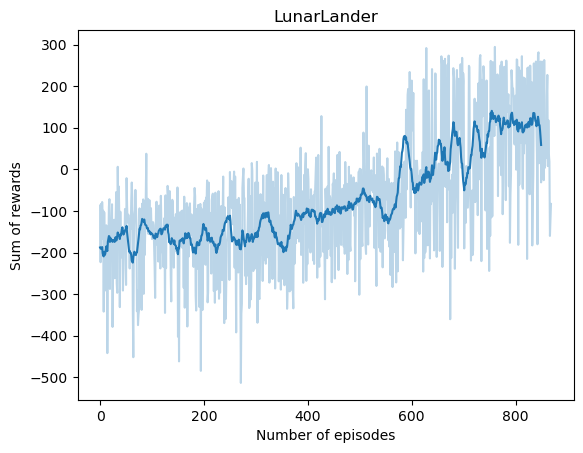

In [7]:
from copy import deepcopy

alpha = 1e-4  # learning rate
gamma = 0.9  # discount factor
lmbda = 0.95
epsilon = 0.2
num_collection_steps = 10
update_epochs = 5

num_envs = 16  # number of environment instances (= batch size)
num_iterations = 20000  # number of iterations

# create the environment instances, initialize with different random seeds
envs = [create_env(seed=i) for i in range(num_envs)]

# create the actor-critic agent and the optimizer
state_dim = envs[0].observation_space.shape[0]
num_actions = envs[0].action_space.n
ac = PPO(state_dim, num_actions, gamma, lmbda, epsilon, num_collection_steps)
optimizer = optim.Adam(ac.parameters(), lr=alpha)

# reset all environment instances
env_states = []
for env in envs:
    state, _ = env.reset()
    env_states.append(torch.as_tensor(state))

# only for plotting
reward_sums = torch.zeros(num_envs)
episode_rewards = []

for _ in trange(num_iterations // num_collection_steps, desc="Iteration"):
    ac.eval()  # switch to evaluation mode

    # step all environment instances and store results in these lists:

    states = []
    actions = []
    rewards = []
    next_states = []
    terminations = []
    truncations = []

    for i in range(num_envs):

        state = env_states[i]
        for _ in range(num_collection_steps):

            action = ac.select_actions(state.unsqueeze(0)).squeeze()
            next_state, reward, terminated, truncated, _ = envs[i].step(action.item())

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            terminations.append(terminated)
            truncations.append(truncated)

            reward_sums[i] += reward

            if terminated:
                state, _ = envs[i].reset()
                state = torch.as_tensor(state)

                episode_rewards.append(reward_sums[i].item())
                reward_sums[i] = 0
            else:
                state = torch.as_tensor(next_state)

        env_states[i] = deepcopy(state)

    # convert the lists to tensors
    states = torch.cat([state.unsqueeze(0) for state in states])
    actions = torch.as_tensor(np.array(actions, dtype=np.int64))
    rewards = torch.as_tensor(np.array(rewards, dtype=np.float32))
    next_states = torch.as_tensor(np.array(next_states))
    terminations = torch.as_tensor(np.array(terminations))
    truncations = torch.as_tensor(np.array(truncations))

    # optimize the actor and critic networks
    ac.train()  # switch to training mode
    for _ in range(update_epochs):
        advantages, critic_targets = ac.compute_advantages(states, rewards, next_states, terminations)

        with torch.no_grad():
            log_probs_old = ac.compute_log_probs(states, actions)
        actor_loss, critic_loss = ac.compute_loss(states, actions, advantages, critic_targets, log_probs_old)

        total_loss = actor_loss + critic_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

plt.title('LunarLander')
plt.xlabel('Number of episodes')
plt.ylabel('Sum of rewards')
plt.plot(episode_rewards, c='C0', alpha=0.3)
plt.plot(np.convolve(episode_rewards, np.ones(20) / 20, mode='valid'), c='C0');

Evaluate the learned policy:

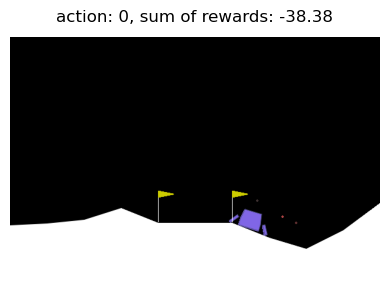

In [8]:
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

state, _ = env.reset()
render()
reward_sum = 0.0

ac.eval()

while True:
    action = ac.select_actions(torch.as_tensor(state).unsqueeze(0)).item()
    state, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'action: {action}, sum of rewards: {reward_sum:.2f}')
    if terminated or truncated:
        break